# Main notebook for testing Mocha

## 0. Load packages



In [1]:
import os
import sys
import copy
import torch
import scipy
import numpy as np
from numpy import matlib as mb
import matplotlib.pyplot as plt
sys.path.append(os.getcwd()+'/assistive_functions')

from household import Household, SyNet
from utils_households import get_lags, connect_to_households

## 1. Load households data

In [2]:
# number of devices and their group
num_households = 20
group="ACORN-L"
stdorToU="ToU"
household_options = {"num_households":num_households,
                    "group":group,
                    "stdorToU":stdorToU}

households = connect_to_households(household_options)



# regression options
options = {"dayparts":[],
           "resolution":60,
           "remove_holiday":True,
           "filt_days":['Tuesday'], 
           "replacement_method":'week_before',
           "feat_cols":['hourofd_x', 'hourofd_y', 'dayofy_x', 'dayofy_y', 'temperature_hourly']}
step_ahead=1

# find dates when all households had data
date_st = []
date_en = []
for household in households:
    household.construct_dataset(lags=get_lags(step_ahead), step_ahead=step_ahead, options=options)
    date_st.append(household.cons_data.date.iloc[0])
    date_en.append(household.cons_data.date.iloc[-1])
date_st_com = max(date_st)
date_en_com = min(date_en)

# construct dataset
for household in households:
    household.construct_dataset(lags=get_lags(step_ahead), step_ahead=step_ahead, options=options, 
                                date_st=date_st_com, date_en=date_en_com)
    household.train_test_split(test_frac=0.25)
    #print(household.info['train_samples'])
    #print(household.info['test_samples'])


Error: data size mismatch

[INFO] Connected to 20 households

Error: data size mismatch

Error: data size mismatch


## 2. Mean-Regularized MTL Training

In [3]:
def print_param(model, message=''):
    with np.printoptions(precision=3, suppress=True):
        print(message+' model: \nbias = ' + 
              str(model.state_dict()['linear.bias'].numpy()[0]) +
              ', \nweights = ' + 
              str(model.state_dict()['linear.weight'].numpy().flatten()))
    return


def get_av_weights(households, **kwargs):
    models = kwargs.get('models', [household.model_mtl for household in households])
    in_dim = households[0].info['num_features']
    # find total samples
    tot_samp = 0
    for household in households:
        tot_samp = tot_samp + household.info['train_samples']
    # init
    bias = np.zeros(1)
    wght = np.zeros(in_dim)
    # aggregate    
    for model in models:
        # aggregate updates
        bias_hh = model.state_dict()['linear.bias'].numpy()
        wght_hh = model.state_dict()['linear.weight'].numpy().flatten()
        bias = bias_hh*household.info['train_samples']/tot_samp + bias
        wght = wght_hh*household.info['train_samples']/tot_samp + wght 
    return bias, wght

    
def mtl_train(households, lr, lambda_, inner_iters, outer_iters, optim_method, **kwargs):
    '''
    optim_method: Adam or SGD
    '''
    np.random.seed(30)
    torch.manual_seed(30)
    
    verbose = kwargs.get('verbose', False)
    # find total samples
    tot_samp = 0
    for household in households:
        tot_samp = tot_samp + household.info['train_samples']
    
    
    # initialize mtl for households
    for household in households:
        household.mtl_init(lr)
    # initialize w_0
    in_dim=households[0].info['num_features']
    w_0 = SyNet(torch, in_dim=in_dim, out_dim=1)
    # find av initial weights
    init_bias, init_wght = get_av_weights(households)
    w_0.state_dict()['linear.weight'].copy_(torch.tensor(init_wght.reshape((1,len(init_wght)))))
    w_0.state_dict()['linear.bias'].copy_(torch.tensor(init_bias))
    init_state_dict=copy.deepcopy(w_0.state_dict())
    
    # create optimizer
    if optim_method=='Adam':
        optim = torch.optim.Adam(params=w_0.parameters(), lr=lr)
    else:
        if optim_method=='SGD':
            optim = torch.optim.SGD(params=w_0.parameters(), momentum=0, lr=lr)
        else:
            print('Unsupported optimization method')
            return
    
    
    # iterate
    for i in np.arange(outer_iters):
        if verbose:
            print('\n before iter ' + str(i))
            print_param(w_0, 'w_0 ')
            
        # initialize param update
        cur_state_dict=copy.deepcopy(w_0.state_dict())
        w_0_wght = w_0.state_dict()['linear.weight']
        w_0_bias = w_0.state_dict()['linear.bias']
        delta_bias = np.zeros(1)
        delta_wght = np.zeros(in_dim)
        # run minibatch SGD for each household
        for household in households:
            # run minibatch SGD and get update in parameters
            db, dw = household.mtl_iterate(w_0_wght=w_0_wght, w_0_bias=w_0_bias,
                                           inner_iters=inner_iters, 
                                           lambda_=lambda_, verbose=False)
            # aggregate updates
            delta_bias = db*household.info['train_samples']/tot_samp + delta_bias
            delta_wght = dw*household.info['train_samples']/tot_samp + delta_wght
            # reset w_0
            for key, value in cur_state_dict.items():
                w_0.state_dict()[key].copy_(value)
        # update w_0
        new_bias = w_0_bias + torch.tensor(delta_bias.reshape((1)))
        new_wght = w_0_wght + torch.tensor(delta_wght.reshape((1,in_dim)))
        w_0.state_dict()['linear.weight'].copy_(new_wght)
        w_0.state_dict()['linear.bias'].copy_(new_bias)
        #print_param(w_0, 'Iteration ' + str(i) + ' ')

        #print(' ')
    # print trained parameters
    #print_param(w_0, 'Trained w_0 ')
    return w_0, init_state_dict

In [4]:
inner_iters = 20
outer_iters = 20
lr = 0.1
lambda_ = 10

w_0, init_state_dict = mtl_train(households, lr=lr, lambda_=lambda_, 
          inner_iters=inner_iters, outer_iters=outer_iters, 
          optim_method='Adam', verbose=False)

## 3. Sanity Check
This section is for checking if the distributed MTL algorithm works correctly by experimenting with two extreme cases, when lambda=0 and lambda is very large. 

### 3.1 No regularization
First, we set lambda=0 to remove the regularization term. In this scenario, the MTL algorithm must return the same models as if each household fits a personal model on its' own local dataset. We run two tests: 1) apply MTL with lambda=0, 2) fit linear models to local datasets separately. If initiated at the same parameters, both methods return the same weights and bias. 

In [5]:
# METHOD 1: MTL
inner_iters = 20
outer_iters = 20
lr = 0.1
lambda_ = 0
w_0, init_state_dict = mtl_train(households, lr=lr, lambda_=lambda_, 
          inner_iters=inner_iters, outer_iters=outer_iters, 
          optim_method='Adam', verbose=False)

# METHOD 2: separate local models
for household in households:
    household.fit_personal_model(method='Adam', lr=lr, 
                                 iterations = inner_iters*outer_iters, 
                                 init_params=init_state_dict)

# Compare
tol = 1e-3
# compare mean model
av_bias, av_wght = get_av_weights(households, models = [household.personal_lr for household in households]) 
w_0_bias = w_0.state_dict()['linear.bias'].numpy()
w_0_wght = w_0.state_dict()['linear.weight'].numpy().flatten()
dff_bias = np.abs(av_bias - w_0_bias)
dff_wght = np.abs(av_wght - w_0_wght)
if np.all(dff_bias<tol) and np.all(dff_wght<tol):
    matched=True
else:
    matched=False
    print('\nSanity check lambda=0 failed.')
    
# compare personal models
if matched:
    for household in households:
        plr_bias = household.personal_lr.state_dict()['linear.bias'].numpy()
        plr_wght = household.personal_lr.state_dict()['linear.weight'].numpy().flatten()
        mtl_bias = household.model_mtl.state_dict()['linear.bias'].numpy()
        mtl_wght = household.model_mtl.state_dict()['linear.weight'].numpy().flatten()
        dff_bias = np.abs(plr_bias - mtl_bias)
        dff_wght = np.abs(plr_wght - mtl_wght)
        if np.all(dff_bias<tol) and np.all(dff_wght<tol):
            matched=True
        else:
            matched=False
            print('\nSanity check lambda=0 failed.')
            break
    if matched:
        print('\nSanity check lambda=0 was successful.')


Sanity check lambda=0 failed.


#### 3.2 Highly regularized

In [6]:
inner_iters = 2000
outer_iters = 1
lr = 1
lambda_ = 1000
w_0, init_state_dict = mtl_train(households, lr=lr, lambda_=lambda_, 
          inner_iters=inner_iters, outer_iters=outer_iters, 
          optim_method='Adam', verbose=False)

# Compare
tol = 1e-2
w_0_bias = w_0.state_dict()['linear.bias'].numpy()
w_0_wght = w_0.state_dict()['linear.weight'].numpy().flatten()
for household in households:
    print_param(household.model_mtl)
    mtl_bias = household.model_mtl.state_dict()['linear.bias'].numpy()
    mtl_wght = household.model_mtl.state_dict()['linear.weight'].numpy().flatten()
    dff_bias = np.abs(w_0_bias - mtl_bias)
    dff_wght = np.abs(w_0_wght - mtl_wght)
    if np.all(dff_bias<tol) and np.all(dff_wght<tol):
        matched=True
    else:
        matched=False
        print('\nSanity check lambda=inf failed.')
        break
if matched:
    print('\nSanity check lambda=inf was successful.')

 model: 
bias = 0.0061900206, 
weights = [-0.03  -0.074  0.082 -0.028  0.048  0.011  0.111  0.032  0.037 -0.005
  0.027 -0.002 -0.057]

Sanity check lambda=inf failed.


## 4. Benchmarking

In [7]:
def compute_av_consumption(households):
    # check length of data
    data_len_trn = households[0].info['train_samples']
    data_len_tst = households[0].info['test_samples']
    for household in households:
        if not household.info['train_samples']==data_len_trn:
            print('[Error] number of train samples of households was not equal')
            return
        if not household.info['test_samples']==data_len_tst:
            print('[Error] number of test samples of households was not equal')
            return
    
    # initialize average consumption
    y_av_trn = np.zeros((data_len_trn,1))
    y_av_tst = np.zeros((data_len_tst,1))
    # add up
    for household in households:
        y_av_trn += household.y_train
        y_av_tst += household.y_test
    # scale
    y_av_trn = y_av_trn/len(households)
    y_av_tst = y_av_tst/len(households)
    # flatten
    y_av_trn = y_av_trn.flatten()
    y_av_tst = y_av_tst.flatten()
    
    return y_av_trn, y_av_tst


# get real values
y_av_trn, y_av_tst = compute_av_consumption(households)

In [ ]:
lr = 0.1
iterations = inner_iters
in_dim=households[0].info['num_features']
benchmark_models=[]

for household in households:
    model = SyNet(torch, in_dim=in_dim , out_dim=1)
    optim = torch.optim.Adam(params=model.parameters(),lr=lr)
    # iterate
    for i in range(iterations):
        optim.zero_grad()
        # predict
        output = model(torch.FloatTensor(household.X_train))
        # calculate loss
        loss = torch.nn.functional.mse_loss(output, torch.FloatTensor(y_av_trn.reshape(-1, 1)))
        loss.backward()
        optim.step()
        if verbose:
            print("Epoch ", i, " train loss", loss.item())
            print(model.state_dict())
    models.append(model)

In [ ]:
#TODO

## 5. Performance Test

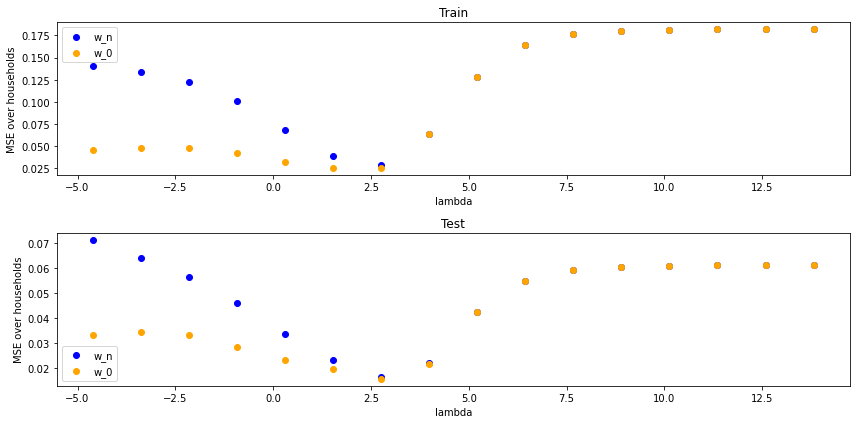

In [15]:
# MTL params
inner_iters = 20
outer_iters = 20
lr = 0.1
lambdas = np.logspace(-2,6,num=16)

# init
mse_w_n_trn = np.zeros((len(households), len(lambdas)))
mse_w_n_tst = np.zeros((len(households), len(lambdas)))
mse_w_0_trn = np.zeros((len(households), len(lambdas)))
mse_w_0_tst = np.zeros((len(households), len(lambdas)))

# grid search lambda
for l_ind, lambda_ in enumerate(lambdas): 
    w_0, init_state_dict = mtl_train(households, lr=lr, lambda_=lambda_, 
              inner_iters=inner_iters, outer_iters=outer_iters, 
              optim_method='Adam', verbose=False)

    # predict
    for h_ind, household in enumerate(households): 
        # predict with w_n 
        pred_w_n_trn = household.predict(household.X_train, method='MTL')
        pred_w_n_tst = household.predict(household.X_test,  method='MTL')
        # predict with w_0
        pred_w_0_trn = household.predict(household.X_train, method='MTL', model=w_0)
        pred_w_0_tst = household.predict(household.X_test,  method='MTL', model=w_0)
        # errors of w_n
        mse_w_n_trn[h_ind, l_ind] = np.mean((pred_w_n_trn-y_av_trn)**2)
        mse_w_n_tst[h_ind, l_ind] = np.mean((pred_w_n_tst-y_av_tst)**2)
        # errors of w_0
        mse_w_0_trn[h_ind, l_ind] = np.mean((pred_w_0_trn-y_av_trn)**2)
        mse_w_0_tst[h_ind, l_ind] = np.mean((pred_w_0_tst-y_av_tst)**2)
    
# mean and std of errors
mse_w_n_trn_av = np.mean(mse_w_n_trn, axis=0)
mse_w_n_tst_av = np.mean(mse_w_n_tst, axis=0)
mse_w_0_trn_av = np.mean(mse_w_0_trn, axis=0)
mse_w_0_tst_av = np.mean(mse_w_0_tst, axis=0)
mse_w_n_trn_sd = np.var(mse_w_n_trn, axis=0)**0.5
mse_w_n_tst_sd = np.var(mse_w_n_tst, axis=0)**0.5
mse_w_0_trn_sd = np.var(mse_w_0_trn, axis=0)**0.5
mse_w_0_tst_sd = np.var(mse_w_0_tst, axis=0)**0.5

# plot
fig,axs = plt.subplots(2,1,figsize=(12,6))
axs[0].scatter(np.log(lambdas), mse_w_n_trn_av, color='blue', label='w_n')
axs[0].scatter(np.log(lambdas), mse_w_0_trn_av, color='orange', label='w_0')
axs[0].set_title('Train')
axs[1].scatter(np.log(lambdas), mse_w_n_tst_av, color='blue', label='w_n')
axs[1].scatter(np.log(lambdas), mse_w_0_tst_av, color='orange', label='w_0')
axs[1].set_title('Test')
for ax in axs:
    ax.legend()
    ax.set_xlabel('lambda')
    ax.set_ylabel('MSE over households')
plt.tight_layout()
plt.show()

## 1.2 Central Training (TO DO)
Problem setup:
* Training data from all households is available simultaneously at a data center 

Algorithm:
* Training datasets from all households are augmented into a single matrix
* Training iterations are executed on the augmented dataset

In [10]:
def central_train(households, optim_method, lr, lambda_, total_it, **kwargs):
    np.random.seed(30)
    torch.manual_seed(30)
    
    # find total samples
    tot_samp = 0
    for household in households:
        tot_samp = tot_samp + household.info['train_samples']
    d = households[0].info['num_features']
    N = len(households)
    C = mb.repmat(np.eye(d), N, N)
    X_train_aug = np.zeros((tot_samp, N*d))
    y_train_aug = np.zeros((tot_samp, 1))
    ind = 0
    # Augment training datasets
    for h_ind, household in enumerate(households):
        num = household.info['train_samples']
        # feat cols
        X_train_aug[ind:ind+num, h_ind*d:h_ind*d+d] = household.X_train
        y_train_aug[ind:ind+num,:] = household.y_train
    
    if 'init_state_dict' in kwargs:
        set_init = True
        init_state_dict = kwargs.get('init_state_dict')
    else:
        set_init = False
    # create an initial model with random parameters
    in_dim=households[0].info['num_features']
    model = SyNet(torch, in_dim=in_dim*N, out_dim=1)
    if set_init:
        for key, value in init_state_dict.items():
            model.state_dict()[key].copy_(value)
        #print_param(model, 'Initial CA ')
    # create optimizer
    if optim_method=='Adam':
        optim = torch.optim.Adam(params=model.parameters(), lr=lr)
    else:
        if optim_method=='SGD':
            optim = torch.optim.SGD(params=model.parameters(), momentum=0, lr=lr)
        else:
            print('Unsupported optimization method')
            return
        
    # iterate
    for i in range(total_it):
        optim.zero_grad()
        # predict
        output = model(torch.FloatTensor(X_train_aug))
        # calculate loss
        loss = torch.nn.MSELoss()(output, torch.FloatTensor(y_train_aug.reshape(-1, 1)))
        #W = np.hstack((cur_state_dict['linear.bias'].numpy(), cur_state_dict['linear.weight'].numpy().flatten()))
        curr_wght = model.parameters()[0]
        curr_bias = model.parameters()[1]
        W = curr_wght.detach().numpy().transpose()
        W_bar = torch.FloatTensor(np.matmul(C,W))
        l2_reg = torch.tensor(0.)
        # only regularize weights not the bias
        l2_reg += torch.norm(curr_wght-W_bar)
        loss += lambda_ * l2_reg
        loss.backward()
        optim.step()
        #print("Epoch ", i, " train loss", loss.item())

    # print trained parameters
    print_param(model, 'Trained CA ')
    return model

In [11]:
total_it=10
#total_it=inner_iters*outer_iters
w_cent = central_train(households, optim_method='Adam', 
              lr=lr, lambda_=10, total_it=total_it, verbose=True)

weights_cent_all = copy.deepcopy(w_cent.state_dict())['linear.weight'].numpy().flatten()
in_dim = households[0].info['num_features']
w_0_cent = np.zeros(in_dim)
for h_ind in np.arange(len(households)):
    w_0_cent = w_0_cent + weights_cent_all[h_ind*in_dim:(h_ind+1)*in_dim]


Trained CA  model: 
bias = -0.71350485, 
weights = [0.742 0.749 0.967 0.733 0.748 0.749 0.742 0.965 0.969 0.746 0.751 0.965
 0.742 0.969 0.956 0.965 0.728 0.943 0.952 0.752 0.741 0.965 0.964 0.748
 0.962 0.968 0.966 0.965 0.946 0.961 0.731 0.962 0.952 0.965 0.968 0.966
 0.959 0.967 0.957 0.969 0.945 0.965 0.949 0.965 0.96  0.964 0.734 0.745
 0.946 0.968 0.966 0.968 0.962 0.966 0.966 0.963 0.743 0.746 0.968 0.955
 0.96  0.962 0.736 0.968 0.737 0.956 0.736 0.951 0.735 0.962 0.968 0.967
 0.745 0.963 0.968 0.741 0.737 0.748 0.964 0.732 0.959 0.742 0.959 0.96
 0.964 0.968 0.968 0.962 0.751 0.949 0.752 0.75  0.743 0.966 0.956 0.964
 0.75  0.954 0.958 0.967 0.743 0.747 0.748 0.748 0.743 0.734 0.967 0.957
 0.749 0.734 0.966 0.74  0.967 0.946 0.968 0.962 0.961 0.751 0.963 0.963
 0.742 0.956 0.966 0.966 0.959 0.745 0.966 0.947 0.742 0.746 0.962 0.96
 0.733 0.961 0.96  0.965 0.735 0.966 0.753 0.954 0.964 0.949 0.959 0.742
 0.965 0.963 0.741 0.74  0.741 0.75  0.968 0.968 0.749 0.741 0.964 0.955
 0